## Video Game Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

### Importing and Transforming Dataset

The information used in the dataset was obtained from <a href="https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings">Video Game Sales with Ratings</a> in Kaggle, which were web scraped by Gregory Smith from VGChartz Video Games Sales. The collection of data includes details such as the game's title, genre, the platform it runs on, the company that published it, and other relevant information.

In [2]:
video_games_df = pd.read_csv("./Dataset/Video Games Sales.csv")

print(f"No. of records: {video_games_df.shape}")
video_games_df.head(5)

No. of records: (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


We removed certain features from the dataset as they are not significant for our recommendation system.

In [3]:
video_games_filtered_df = video_games_df[['Name', 'Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  8137 non-null   float64
 4   User_Score    10015 non-null  object 
 5   Rating        9950 non-null   object 
dtypes: float64(1), object(5)
memory usage: 783.8+ KB


### Exploratory Data Analysis

Check all missing values in the dataset for each feature

In [4]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Critic_Score    8582
Rating          6769
User_Score      6704
Name               2
Genre              2
Platform           0
dtype: int64

Remove any data that is incomplete or missing in the `Name` and `Genre` features, and substitute the term `Unknown` for any missing information in the `Rating` field.

In [5]:
video_games_filtered_df.dropna(subset=['Name', 'Genre'], axis=0, inplace=True)
video_games_filtered_df = video_games_filtered_df.reset_index(drop=True)

video_games_filtered_df.fillna({'Rating' : 'Unknown'}, inplace=True)

video_games_filtered_df[['Name', 'Genre', 'Rating']].isna().sum()

Name      0
Genre     0
Rating    0
dtype: int64

Examine the frequency of data types for each categorical feature: `Genre`, `Platform`, and `Rating`.

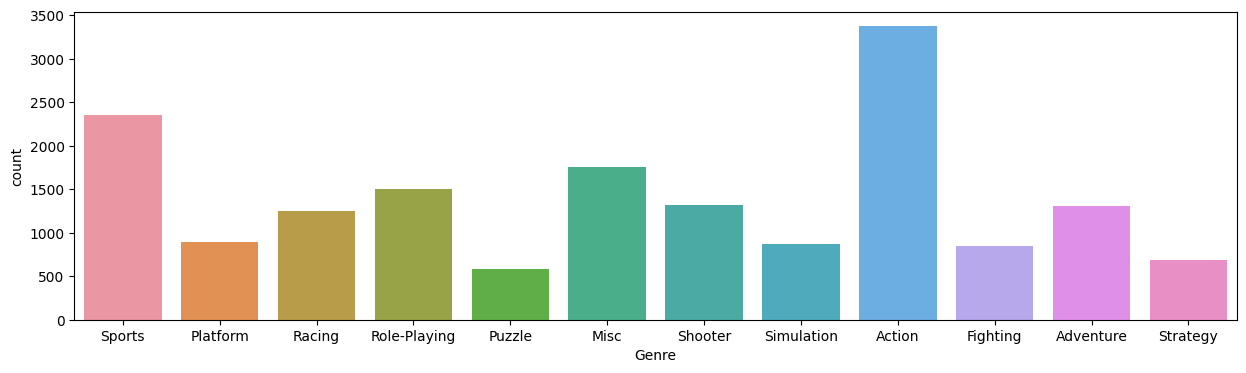

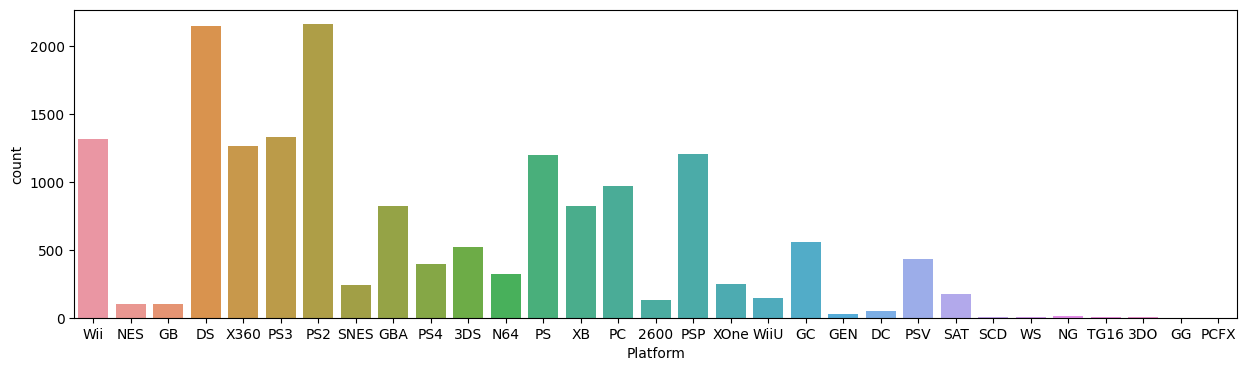

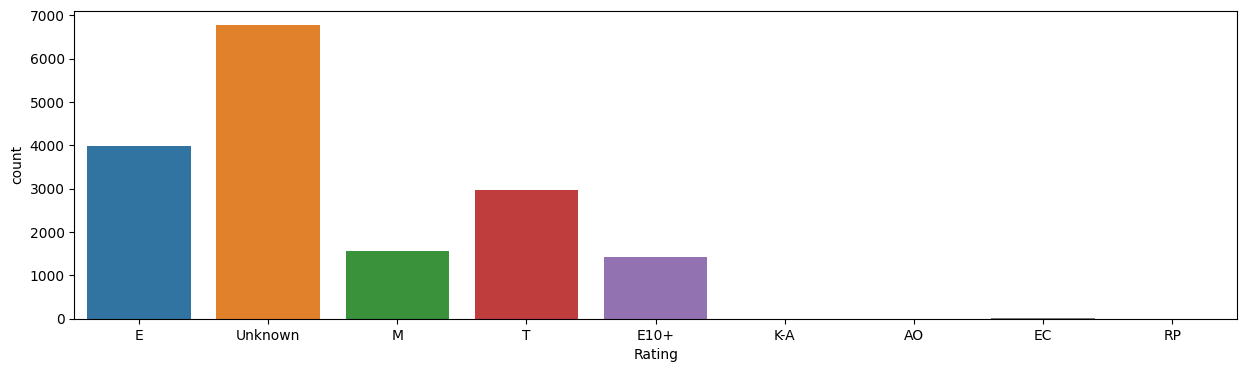

In [6]:
features = video_games_filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (15,4))
    sns.countplot(data=video_games_filtered_df, x=feature)
plt.show()

Create additional features that correspond to the `User_Score` and `Critic_score` variables, and replace any missing or 'tbd' values with a specific substitute. The substitute will be calculated as the mean value of the `User_Score` or `Critic_score` variable within a particular genre, such as the average of all scores under the 'Action' category.

In [7]:
# Replace 'tbd' value to NaN
video_games_filtered_df['User_Score'] = np.where(video_games_filtered_df['User_Score'] == 'tbd', np.nan, video_games_filtered_df['User_Score']).astype(float)

# Group the records by Genre, then aggregate them calculating the average of both  Critic Score and User Score
video_game_score_mean = video_games_filtered_df[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False).agg(Ave_Critic_Score = ('Critic_Score', 'mean'), 
                                                                                                                              Ave_User_Score = ('User_Score', 'mean'))

# Merge the average scores with the main dataframe
video_games_filtered_df = video_games_filtered_df.merge(video_game_score_mean, on='Genre')
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,76.0,8.0,E,71.968174,6.961197
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,71.968174,6.961197
2,Wii Fit,Wii,Sports,80.0,7.7,E,71.968174,6.961197
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,71.968174,6.961197
4,FIFA 16,PS4,Sports,82.0,4.3,E,71.968174,6.961197
...,...,...,...,...,...,...,...,...
16712,Codename: Panzers Complete Collection,PC,Strategy,NaN,NaN,Unknown,72.086093,7.295177
16713,Hospital Tycoon,PC,Strategy,51.0,3.8,E10+,72.086093,7.295177
16714,End of Nations,PC,Strategy,NaN,NaN,T,72.086093,7.295177
16715,Worms 2,PC,Strategy,NaN,8.1,K-A,72.086093,7.295177


In [8]:
video_games_filtered_df['Critic_Score_Upd'] = np.where(video_games_filtered_df['Critic_Score'].isna(), video_games_filtered_df['Ave_Critic_Score'], video_games_filtered_df['Critic_Score'])
video_games_filtered_df['User_Score_Upd'] = np.where(video_games_filtered_df['User_Score'].isna(),  video_games_filtered_df['Ave_User_Score'], video_games_filtered_df['User_Score'])
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Upd,User_Score_Upd
0,Wii Sports,Wii,Sports,76.0,8.0,E,71.968174,6.961197,76.000000,8.000000
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,71.968174,6.961197,80.000000,8.000000
2,Wii Fit,Wii,Sports,80.0,7.7,E,71.968174,6.961197,80.000000,7.700000
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,71.968174,6.961197,80.000000,7.400000
4,FIFA 16,PS4,Sports,82.0,4.3,E,71.968174,6.961197,82.000000,4.300000
...,...,...,...,...,...,...,...,...,...,...
16712,Codename: Panzers Complete Collection,PC,Strategy,NaN,NaN,Unknown,72.086093,7.295177,72.086093,7.295177
16713,Hospital Tycoon,PC,Strategy,51.0,3.8,E10+,72.086093,7.295177,51.000000,3.800000
16714,End of Nations,PC,Strategy,NaN,NaN,T,72.086093,7.295177,72.086093,7.295177
16715,Worms 2,PC,Strategy,NaN,8.1,K-A,72.086093,7.295177,72.086093,8.100000


Check again if there are any features with missing values, excluding `Critic_Score` and `User_Score` since these features will be replaced by `Critic_Score_Upd` and `User_Score_Upd`

In [9]:
video_games_final_df = video_games_filtered_df.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
video_games_final_df = video_games_final_df.rename(columns={'Critic_Score_Upd':'Critic_Score', 'User_Score_Upd':'User_Score'})
video_games_final_df.isna().sum().sort_values(ascending=False)

Name            0
Platform        0
Genre           0
Rating          0
Critic_Score    0
User_Score      0
dtype: int64

Examine and compare the summary statistics of `User_Score` and `Critic_Score` and their respective new features (`User_Score_Upd` and `Critic_Score_Upd`) with imputed missing values. Below shows that filling in the missing values did not have an impact on the average of the data. The standard deviation of the critic score has gone down by around 4, as expected, and a marginal difference for user score.

In [10]:
video_games_filtered_df[['Critic_Score', 'Critic_Score_Upd',  'User_Score', 'User_Score_Upd']].describe()

,Critic_Score,Critic_Score_Upd,User_Score,User_Score_Upd
count,8137.000000,16717.000000,7590.000000,16717.000000
mean,68.967679,68.760119,7.125046,7.115051
std,13.938165,9.888363,1.500006,1.022320
min,13.000000,13.000000,0.000000,0.000000
25%,60.000000,66.619503,6.400000,6.961197
50%,71.000000,68.058350,7.500000,7.133000
75%,79.000000,72.652646,8.200000,7.600000
max,98.000000,98.000000,9.700000,9.700000


Analyze the data distribution for `Critic_Score` and `User_Score`, and assess the correlation between these features.

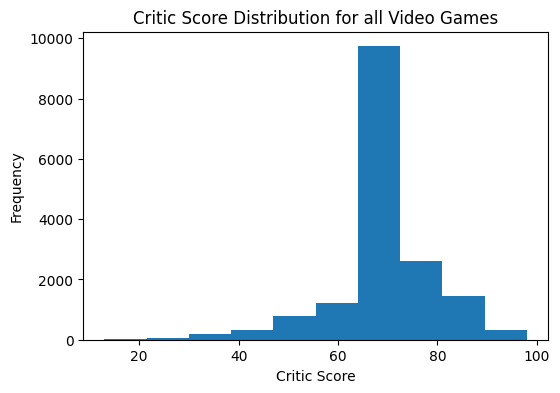

In [11]:
plt.figure(figsize=(6,4))
plt.hist(video_games_final_df['Critic_Score'], bins=10)
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.title("Critic Score Distribution for all Video Games")
plt.show()

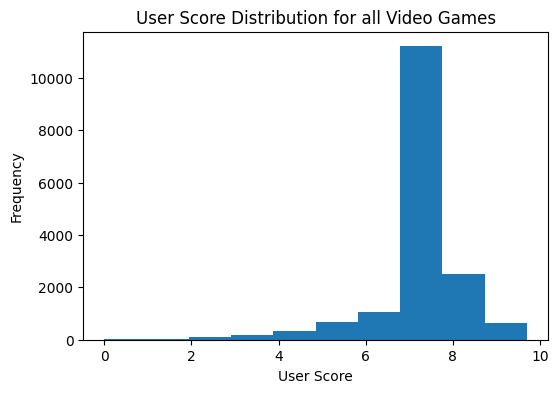

In [12]:
plt.figure(figsize=(6,4))
plt.hist(video_games_final_df['User_Score'], bins=10)
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.title("User Score Distribution for all Video Games")
plt.show()

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Critic Scores')]

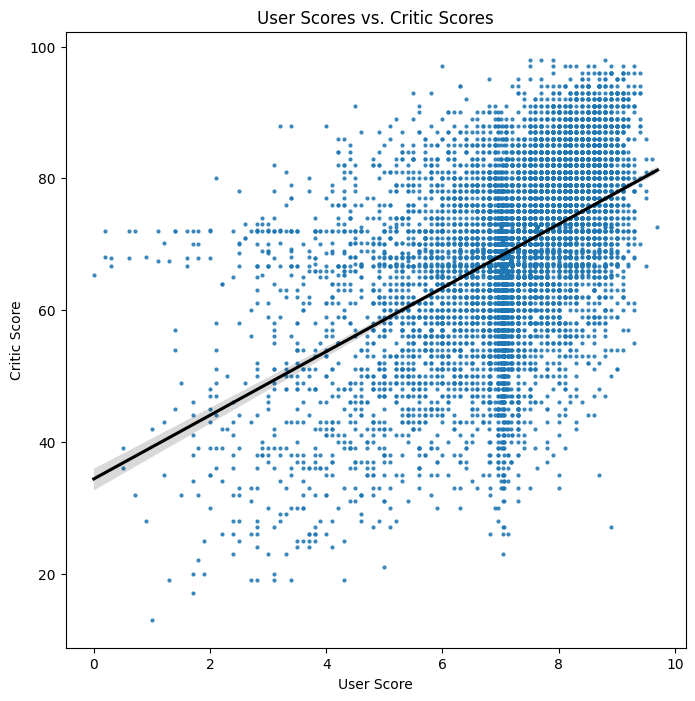

In [13]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=video_games_final_df['User_Score'], y=video_games_final_df['Critic_Score'], line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Critic Scores")

Perform a last verification of the dataframe details prior to transforming the categorical attributes into dummary indicators.

In [14]:
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16717 entries, 0 to 16716
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16717 non-null  object 
 2   Genre         16717 non-null  object 
 3   Rating        16717 non-null  object 
 4   Critic_Score  16717 non-null  float64
 5   User_Score    16717 non-null  float64
dtypes: float64(2), object(4)
memory usage: 914.2+ KB


### Converting Categorical Features to Dummy Indicators

Get all categorical features

In [15]:
categorical_columns = [name for name in video_games_final_df.columns if video_games_final_df[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 4 categorical features:

Name, Platform, Genre, Rating


Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [16]:
video_games_df_dummy = pd.get_dummies(data=video_games_final_df, columns=categorical_columns[1:])

video_games_df_dummy.head(5)

,Name,Critic_Score,User_Score,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,...,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T,Rating_Unknown
0,Wii Sports,76.0,8.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Wii Sports Resort,80.0,8.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Wii Fit,80.0,7.7,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,Wii Fit Plus,80.0,7.4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,FIFA 16,82.0,4.3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
video_games_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16717 entries, 0 to 16716
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                16717 non-null  object 
 1   Critic_Score        16717 non-null  float64
 2   User_Score          16717 non-null  float64
 3   Platform_2600       16717 non-null  uint8  
 4   Platform_3DO        16717 non-null  uint8  
 5   Platform_3DS        16717 non-null  uint8  
 6   Platform_DC         16717 non-null  uint8  
 7   Platform_DS         16717 non-null  uint8  
 8   Platform_GB         16717 non-null  uint8  
 9   Platform_GBA        16717 non-null  uint8  
 10  Platform_GC         16717 non-null  uint8  
 11  Platform_GEN        16717 non-null  uint8  
 12  Platform_GG         16717 non-null  uint8  
 13  Platform_N64        16717 non-null  uint8  
 14  Platform_NES        16717 non-null  uint8  
 15  Platform_NG         16717 non-null  uint8  
 16  Plat

### Standardizing the Features

In [18]:
features = video_games_df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,Critic_Score,User_Score,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T,Rating_Unknown
0,0.732184,0.865654,-0.089553,-0.013397,-0.179178,-0.05586,-0.384385,-0.076791,-0.227408,-0.185483,...,-0.20639,-0.007735,1.785686,-0.304678,-0.021881,-0.013397,-0.321156,-0.013397,-0.463952,-0.824682
1,1.136712,0.865654,-0.089553,-0.013397,-0.179178,-0.05586,-0.384385,-0.076791,-0.227408,-0.185483,...,-0.20639,-0.007735,1.785686,-0.304678,-0.021881,-0.013397,-0.321156,-0.013397,-0.463952,-0.824682
2,1.136712,0.572195,-0.089553,-0.013397,-0.179178,-0.05586,-0.384385,-0.076791,-0.227408,-0.185483,...,-0.20639,-0.007735,1.785686,-0.304678,-0.021881,-0.013397,-0.321156,-0.013397,-0.463952,-0.824682
3,1.136712,0.278736,-0.089553,-0.013397,-0.179178,-0.05586,-0.384385,-0.076791,-0.227408,-0.185483,...,-0.20639,-0.007735,1.785686,-0.304678,-0.021881,-0.013397,-0.321156,-0.013397,-0.463952,-0.824682
4,1.338976,-2.753672,-0.089553,-0.013397,-0.179178,-0.05586,-0.384385,-0.076791,-0.227408,-0.185483,...,-0.20639,-0.007735,1.785686,-0.304678,-0.021881,-0.013397,-0.321156,-0.013397,-0.463952,-0.824682


### Creating a Model

We will use `NearestNeighbors` model to find similar items. It is a machine learning algorithm that belongs to the category of unsupervised learning algorithms, which is used for finding the k-nearest neighbors of a data point or a set of data points in a given dataset.

In [19]:
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(scaled_features)
print(nn)

distances, indices = nn.kneighbors(scaled_features)

NearestNeighbors(algorithm='ball_tree', n_neighbors=10)


### Testing the Model

In [30]:
def VideoGameRecommender(video_game_name, video_game_platform=None):

    if video_game_platform == None:
        video_game_idx = video_games_final_df.query("Name == @video_game_named").index
    else:
        video_game_idx = video_games_final_df.query("Name == @video_game_name & Platform == @video_game_platform").index

    if video_game_idx.empty:
        print(f"The game '{video_game_name}' under platform '{video_game_platform}' doesn't exist in the records.")
        return None

    else :
        print(f"Top 10 Recommended Video Games for '{video_game_name}' (platform:{video_game_platform})\n")

        for idx, newid in enumerate(indices[video_game_idx[0]]):
            print(f"{idx+1}. {video_games_final_df.loc[newid].Name}")

In [21]:
VideoGameRecommender('Call of Duty: Advanced Warfare', 'XOne')

Top 10 Recommended Video Games for 'Call of Duty: Advanced Warfare' (platform:XOne)

1. Call of Duty: Advanced Warfare
2. Evolve
3. Gears of War 4
4. Battlefield: Hardline
5. Titanfall
6. Call of Duty: Ghosts
7. Battlefield 4
8. Tom Clancy's The Division
9. Tom Clancy's Rainbow Six: Siege
10. Halo: The Master Chief Collection


In [22]:
VideoGameRecommender('Wii Sports', 'XOne')

The game 'Wii Sports' under platform 'XOne' doesn't exist in the records.


Test games and/platform that is not included in the dataset to train the predictive model

In [23]:
VideoGameRecommender('Wii Sport IV', 'Wii')

The game 'Wii Sport IV' under platform 'Wii' doesn't exist in the records.


In [29]:
VideoGameRecommender('Diablo III', 'PC')

Top 10 Recommended Video Games for 'Diablo III' (platform:PC)

1. Diablo III
2. Fallout 4
3. Mass Effect 3
4. Dragon Age: Inquisition
5. Fable III
6. Deus Ex: Mankind Divided
7. The Elder Scrolls Online
8. Risen 2: Dark Waters
9. Kingdoms of Amalur: Reckoning
10. Two Worlds II


In [31]:
VideoGameRecommender('Diablo III', 'XOne')

Top 10 Recommended Video Games for 'Diablo III' (platform:XOne)

1. Diablo III
2. Dark Souls II
3. The Elder Scrolls V: Skyrim
4. Divinity: Original Sin
5. Final Fantasy Type-0
6. Dark Souls III
7. The Technomancer
8. Wasteland 2
9. The Elder Scrolls Online
10. Lords of the Fallen


### References

1. https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
2. https://thecleverprogrammer.com/2021/01/17/book-recommendation-system/

> BDM-3014 Winter 2023 Project (Group 12)